<a href="https://colab.research.google.com/github/dralvima/IITmethods/blob/main/Soccer_PHImax_state_timeseries_with_mechanisms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **COMPUTE PHImax FOR 3 PLAYER SOCCER DATA**

**1. Import Data**

In [1]:
import numpy as np
from google.colab import files
import numpy as np

# Create an upload button in the notebook
uploaded = files.upload()

# Assuming you upload only one file, get the filename
filename = next(iter(uploaded.keys()))

# Load the .npz file (I used: 'Data_timeseries_Alex.npz')
data = np.load(filename)

# Accessing data
# If you know the key, you can directly access the data
# For example, if the key is 'arr_0':
time_series_data = data['arr_0']

Saving Data_timeseries_Alex.npz to Data_timeseries_Alex.npz


quick look to double check

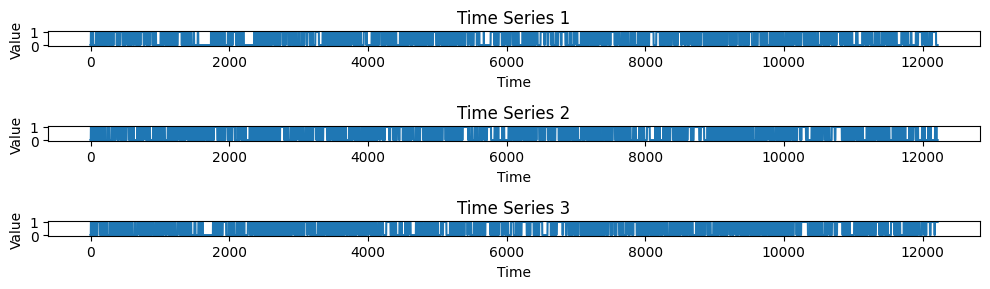

In [2]:
import matplotlib.pyplot as plt

# Assuming time_series_data is your loaded data with shape (3, N)
# where N is the number of time points

# Create a figure and a set of subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 3))

# Titles for each subplot
titles = ['Time Series 1', 'Time Series 2', 'Time Series 3']

# Plot each time series in a separate subplot
for i in range(3):
    axs[i].plot(time_series_data[i])
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Value')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

**Compute TPM** *THIS CODE WILL WORK FOR ANY NUMBER OF PLAYERS AND RETURN IN LITTLE ENDIAN*

In [3]:
from itertools import product
import numpy as np

def compute_transition_probability_matrix(time_series_data):
    # Infer the number of states from the data (assuming binary data, the max value + 1)
    num_states = int(np.max(time_series_data) + 1)

    # Number of players
    num_players = time_series_data.shape[0]

    # Total number of possible states (2^num_players)
    total_states = num_states ** num_players

    # Initialize the transition probability matrix with zeros
    TPM = np.zeros((total_states, total_states))

    # Dynamically generate the correct order of states
    all_states = list(product(range(num_states), repeat=num_players))
    correct_order = sorted(all_states, key=lambda x: (sum(x), x[::-1]))
    state_to_index = {state: index for index, state in enumerate(correct_order)}

    # Count the transitions
    for t in range(time_series_data.shape[1] - 1):
        current_state = tuple(time_series_data[:, t])
        next_state = tuple(time_series_data[:, t + 1])
        current_index = state_to_index[current_state]
        next_index = state_to_index[next_state]
        TPM[current_index, next_index] += 1

    # Normalize the rows to get probabilities
    for i in range(total_states):
        row_sum = np.sum(TPM[i, :])
        if row_sum > 0:
            TPM[i, :] /= row_sum

    return TPM, correct_order

# Example usage
# Compute the transition probability matrix
TPM, state_list = compute_transition_probability_matrix(time_series_data)

take another peek to double check

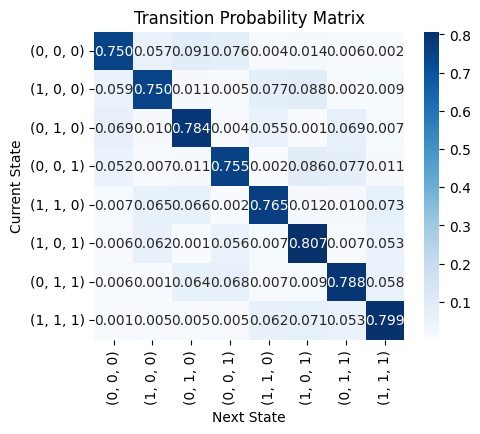

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming TPM and state_list are already defined from previous steps

# Plotting the Transition Probability Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(TPM, annot=True, fmt=".3f", cmap="Blues", xticklabels=state_list, yticklabels=state_list)
plt.title("Transition Probability Matrix")
plt.xlabel("Next State")
plt.ylabel("Current State")
plt.show()

**Launch PiPhy and compute PHI values**

In [5]:
!pip install -U git+https://github.com/wmayner/pyphi.git@feature/iit-4.0
import itertools
import pyphi
# Disable PyPhi progress bars and welcome message
pyphi.config.PROGRESS_BARS = False
pyphi.config.WELCOME_OFF = True

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

# Check if a result file already exists to save time
if not os.path.exists('full_phi_results.pkl'):

  # Setting up the required parameters for pyPhi analysis
  labels = ('A', 'B', 'C')
  num_bits = len(labels)
  possible_states = np.array(list(itertools.product([0, 1], repeat=num_bits)))

  # Function to calculate phi values and states for a single TPM, tracking skipped trials
  def calculate_phi_for_tpm(tpm, possible_states, labels):
      converted_tpm = pyphi.convert.sbs2sbn(tpm)
      network = pyphi.Network(converted_tpm, node_labels=labels)
      node_indices = (0, 1, 2)

      phi_values = np.zeros(len(possible_states))
      phi_states = np.zeros((len(possible_states), 3), dtype=int)

      max_phi = -np.inf
      max_phi_state = None
      phi_mechanisms = []

      for i, state in enumerate(possible_states):
            candidate_system = pyphi.Subsystem(network, state, node_indices)
            phi_structure = pyphi.new_big_phi.phi_structure(candidate_system)
            big_phi = phi_structure.big_phi
            phi_values[i] = big_phi
            phi_states[i] = state
            current_state_mechanisms = [distinction.mechanism for distinction in phi_structure.distinctions]
            phi_mechanisms.append(current_state_mechanisms)
            if big_phi > max_phi:
                max_phi = big_phi
                max_phi_state = state

      return phi_values, phi_states, max_phi, max_phi_state, phi_mechanisms

  # Calculate phi values
  phi_values, phi_states, max_phi, max_phi_state, phi_mechanisms = calculate_phi_for_tpm(TPM, possible_states, labels)
  phi_results = calculate_phi_for_tpm(TPM, possible_states, labels)

  # Saving the results and the list of skipped trials
  with open('full_phi_results.pkl', 'wb') as file:
    pickle.dump(phi_results, file)

else:
    print("File 'full_phi_results.pkl' already exists. Skipping computation.")

  Cloning https://github.com/wmayner/pyphi.git (to revision feature/iit-4.0) to /tmp/pip-req-build-5q8s60pe
  Running command git clone --filter=blob:none --quiet https://github.com/wmayner/pyphi.git /tmp/pip-req-build-5q8s60pe
  Resolved https://github.com/wmayner/pyphi.git to commit 83e887db466ed0c617cfb637f94a13d2aae8eea2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.6/662.6 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━

2023-12-20 18:57:21,433	INFO worker.py:1664 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


quick plot

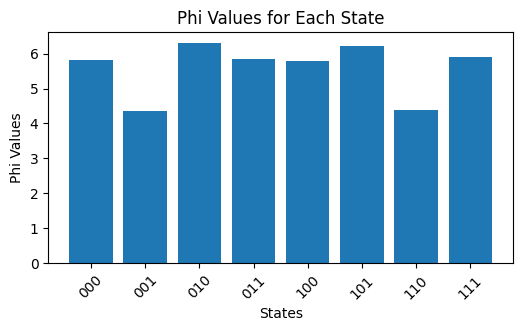

array([0, 1, 0])

In [6]:
import matplotlib.pyplot as plt

# Assuming phi_values and phi_states are already defined
# Convert states to string representations for labeling
state_labels = [''.join(map(str, state)) for state in phi_states]

# Create the bar plot
plt.figure(figsize=(6, 3))
plt.bar(state_labels, phi_values)

# Adding labels and title
plt.xlabel('States')
plt.ylabel('Phi Values')
plt.title('Phi Values for Each State')

# Rotate the state labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

max_phi_state

Re-Map PHI to the state-by-state time series

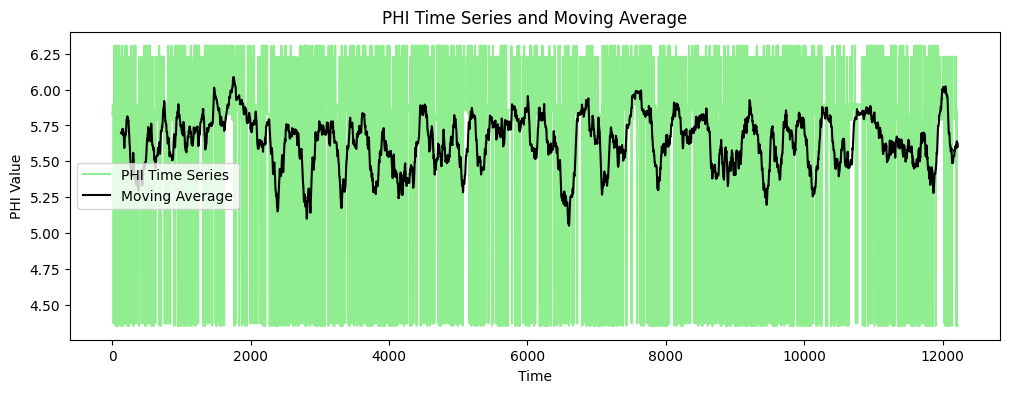

In [7]:
# Extracting the necessary data from phi_results
phi_values = phi_results[0]
phi_states = phi_results[1]

# Mapping each state to its corresponding phi value
state_to_phi = {tuple(state): phi for state, phi in zip(phi_states, phi_values)}

# Reassigning the phi values to the respective states in the original time series sequence
phi_time_series = np.array([state_to_phi[tuple(state)] for state in time_series_data.T])

# Compute a moving average of the phi time series
window_size = 128  # Define the window size for the moving average
moving_avg = np.convolve(phi_time_series, np.ones(window_size) / window_size, mode='valid')

# Plotting the time series of PHI values and the moving average
plt.figure(figsize=(12, 4))
plt.plot(phi_time_series, label='PHI Time Series', color='lightgreen')
plt.plot(np.arange(window_size - 1, len(phi_time_series)), moving_avg, label='Moving Average', color='black')
plt.title('PHI Time Series and Moving Average')
plt.xlabel('Time')
plt.ylabel('PHI Value')
plt.legend()
plt.show()

MECHANISMS (and ARITY) over time

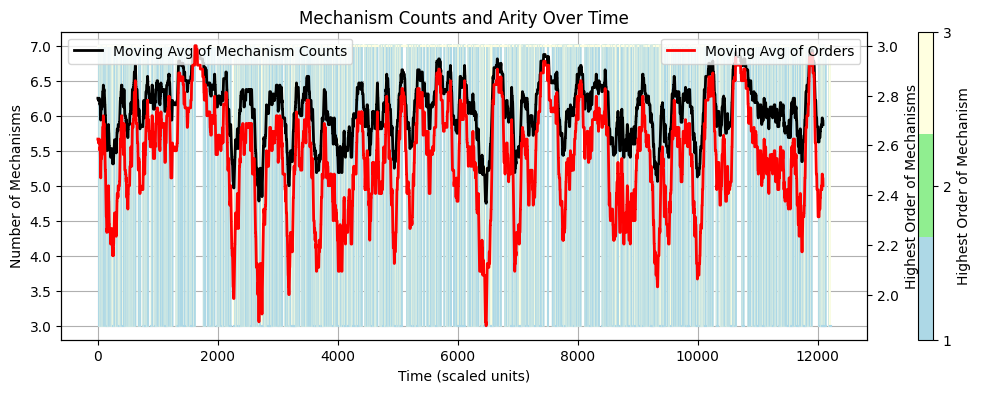

In [9]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

phi_mechanisms = phi_results[4]
state_to_index = {tuple(state): index for index, state in enumerate(phi_states)}

# Function to determine the highest order of mechanism
def highest_order(mechanisms):
    return max(len(m) for m in mechanisms) if mechanisms else 0

# Map the number of mechanisms and their highest orders to the original time series
mechanism_counts = [len(phi_mechanisms[state_to_index[tuple(state)]]) for state in time_series_data.T]
highest_orders = [highest_order(phi_mechanisms[state_to_index[tuple(state)]]) for state in time_series_data.T]

# Maximum order among all mechanisms
max_order = max(highest_orders)

# Define a custom colormap
colors = ['lightblue', 'lightgreen', 'lightyellow']  # For orders 1, 2, 3, ...
cmap = mcolors.ListedColormap(colors[:max_order])

# Normalize highest order for color mapping
norm = plt.Normalize(1, max_order)

# Calculate moving averages
window_size = 128  # Window size for moving averages
moving_avg_mechanism_counts = np.convolve(mechanism_counts, np.ones(window_size)/window_size, mode='valid')
moving_avg_highest_orders = np.convolve(highest_orders, np.ones(window_size)/window_size, mode='valid')

state_to_index = {tuple(state): index for index, state in enumerate(phi_states)}

# Define time_span as the range of time points in the original time series
time_span = np.arange(len(time_series_data.T))

# Recreate the plot with the corrected time_span
fig, ax1 = plt.subplots(figsize=(13, 4))

# Plotting mechanisms and their orders with the correct time_span
for i in range(len(time_span) - 1):
    color_index = highest_orders[i] - 1
    ax1.plot(time_span[i:i+2], mechanism_counts[i:i+2], color=colors[color_index], linestyle='-')

# Plotting moving average of mechanism counts
ax1.plot(time_span[:len(moving_avg_mechanism_counts)], moving_avg_mechanism_counts, color='black', linewidth=2, label='Moving Avg of Mechanism Counts')

# Set up secondary y-axis for moving average of orders
ax2 = ax1.twinx()
ax2.plot(time_span[:len(moving_avg_highest_orders)], moving_avg_highest_orders, color='red', linewidth=2, label='Moving Avg of Orders')

# Create the discrete colorbar
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax1, ticks=range(1, max_order + 1))
cbar.set_label('Highest Order of Mechanism')

# Set labels and titles
ax1.set_title("Mechanism Counts and Arity Over Time")
ax1.set_xlabel("Time (scaled units)")
ax1.set_ylabel("Number of Mechanisms")
ax2.set_ylabel("Highest Order of Mechanisms")
ax1.grid(True)

# Adding legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()